## Extracting Data

In [152]:
import numpy as np
import csv
import os
from tqdm import tqdm

NPZ_DIRPATH = "drive/MyDrive/AngioAssessment/npz"
CSV_DIRPATH = "drive/MyDrive/AngioAssessment/csv"

FNAME = 'arr_0'
NUM_FILES = 5

data = {"1" : [], # keyframed
        "0" : []} # non-keyframed

def prepare_data():
  for i in range(1, 1+NUM_FILES):
    npz_fpath = os.path.join(NPZ_DIRPATH, f"npz-{i}.npz")
    csv_fpath = os.path.join(CSV_DIRPATH, f"csv-{i}.csv")
    annotate_data(npz_fpath, csv_fpath)

def annotate_data(npz_fpath, csv_fpath):
  csv_data = csv.reader(open(csv_fpath, 'r'))
  npz_data = np.load(npz_fpath)[FNAME]

  for index, anno in tqdm(csv_data):
    try:
      data[anno].append([npz_data[int(index)], np.eye(2)[int(anno)]])
    except Exception as e:
      pass

prepare_data()

127it [00:00, 95960.48it/s]
137it [00:00, 100704.46it/s]
175it [00:00, 72451.21it/s]
130it [00:00, 91195.77it/s]
130it [00:00, 31479.68it/s]


---
## Image Visualisation

The two images below are examples of a keyframed and non-keyframed image respectively. Both images are taken from npz-1.npz.

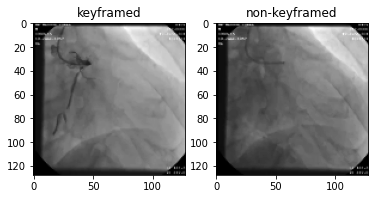

In [143]:
import matplotlib.pyplot as plt

# Extract example of keyframed and non-keyframed data
keyframed_img_eg = data['0'][0]
non_keyframed_img_eg = data['1'][0]

images = list(map(lambda x:x[0][0,:,:], [keyframed_img_eg, non_keyframed_img_eg]))
titles = ["keyframed", "non-keyframed"]

fig, axes = plt.subplots(1, 2)

for i in range(len(images)):
  img = images[i]; title = titles[i]
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(title)

plt.show()

---
## Preparing Data

The data can be viewed as unbalanced, as the counts of keyframed and non-keyframed data are not exactly equal:

In [91]:
print(f"Keyframed count: {len(data['1'])}\nNon-keyframed count: {len(data['0'])}")

Keyframed count: 394
Non-keyframed count: 300


Balancing will be performed by downsampling the majority (keyframed images).

In [153]:
def process_data(data):
  def shuffled_balance(data):
    ls_1, ls_2 = data.values()
    map(np.random.shuffle, (ls_1, ls_2))

    a, b = len(ls_1), len(ls_2)
    target = max(a, b) - abs(a - b)

    data['1'] = ls_1[:target]
    data['0'] = ls_2[:target]

  shuffled_balance(data)

  # verify that both image lists are equal
  assert(len(data['0']) == len(data['1'])) 

  concat = data['1'] + data['0']
  np.random.shuffle(concat)
  return concat

processed_data = process_data(data)

---
## Neural network

In [154]:
"""
NN
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # nn.Conv2d takes the in_channel, out_channel, kernel size
    # the image, being greyscale, only has one channel
    self.conv_1 = nn.Conv2d(1, 32, 3) 
    self.conv_2 = nn.Conv2d(32, 64, 3)
    self.conv_3 = nn.Conv2d(64, 128, 3)

    # Handles the initialisation of in_channels for the first fully connected layer
    self._to_linear = None
    rand_init = torch.randn(128, 128).view(-1, 1, 128, 128) # just pass in random data
    self.run_conv(rand_init)

    self.fc_1 = nn.Linear(self._to_linear, 128)
    self.fc_2 = nn.Linear(128, 2)

  def run_conv(self, x):
    # relu; "discard" negative values
    # max pooling; (2, 2) filter
    x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv_2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv_3(x)), (2, 2))

    # init in_channels for fc_1
    if not self._to_linear:
      self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  def forward(self, x):
    x = self.run_conv(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc_1(x))
    x = self.fc_2(x) # relu not needed, just output the final result
    return F.softmax(x, dim=1)

net = Net()
optimiser = optim.Adam(net.parameters(), lr=0.001) # try with 1e-3 first
loss_fn = nn.MSELoss()

In [155]:
SPLIT_PCT = 0.30 # % of the data used for testing

# normalise to range of 0 to 1
imgs = torch.Tensor(np.array([i[0] for i in processed_data])).view(-1, 128, 128)/255.0
annos = torch.Tensor(np.array([i[1] for i in processed_data]))

val_size = int(len(imgs)*SPLIT_PCT)

training_imgs = imgs[val_size:]
training_annos = annos[val_size:]

testing_imgs = imgs[:val_size]
testing_annos = annos[:val_size]

print(len(training_imgs), len(training_annos))

420 420


In [156]:
from random import sample

def calc_batch_performance(outputs, annotations):
  """
  Calculates and returns a confusion matrix for the current batch of data

  confusion_mat
  -------------
  |         | non_kf    | kf        |
  | non_kf  | true neg  | fals neg  | 
  | kf      | false pos | true pos  | 

  """
  confusion_mat = [[0, 0], 
                   [0, 0]]

  for i, j in zip(outputs, annotations):
    confusion_mat[torch.argmax(i)][torch.argmax(j)] += 1
  
  num_correct = confusion_mat[0][0] + confusion_mat[1][1]
  accuracy = num_correct / sum(map(sum, confusion_mat))
  
  return confusion_mat, accuracy


def forward_pass(images, annotations, training=False):
  images = images.view(-1, 1, 128, 128)

  if training:
    net.zero_grad()

  outputs = net(images)
  confusion_mat, accuracy = calc_batch_performance(outputs, annotations) 
  
  loss = loss_fn(outputs, annotations)

  if training:
    loss.backward()
    optimiser.step()

  return confusion_mat, accuracy, loss

def test(size):
  random_start = np.random.randint(len(testing_imgs)-size)
  sampled_imgs = testing_imgs[random_start:random_start+size]
  sampled_annos = testing_annos[random_start:random_start+size]
  with torch.no_grad():
    confusion_mat, accuracy, loss = forward_pass(sampled_imgs, sampled_annos)
  return confusion_mat, accuracy, loss

# test(30)

In [157]:
accuracy_values = []
loss_values = []
confusion_mats = []

def train():
  BATCH_SIZE = 32
  EPOCHS = 11
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(training_imgs), BATCH_SIZE)):
      batch_imgs = training_imgs[i:i+BATCH_SIZE]
      batch_annos = training_annos[i:i+BATCH_SIZE]

      conf_mat, acc, loss = forward_pass(batch_imgs, batch_annos, training=True)
      if i % 10 == 0:
        test_conf_mat, test_acc, test_loss = test(BATCH_SIZE)
        confusion_mats.append([conf_mat, test_conf_mat])
        accuracy_values.append([acc, test_acc])
        loss_values.append([loss.item(), test_loss.item()])

train()

100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


33


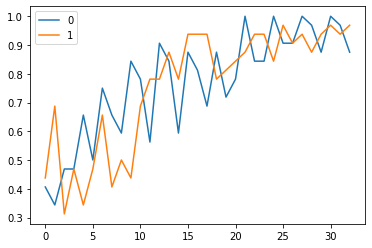

In [159]:
import seaborn as sns
import pandas as pd

acc_df = pd.DataFrame.from_records(accuracy_values)
loss_df = pd.DataFrame.from_records(loss_values)
print(len(accuracy_values))

acc_df.plot()